# Fraction of bright GFP variants vs. #mutations for different GFPs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

In /home/labs/fleishman/jonathaw/Code/anaconda3/envs/dees-seq-analysis/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/labs/fleishman/jonathaw/Code/anaconda3/envs/dees-seq-analysis/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/labs/fleishman/jonathaw/Code/anaconda3/envs/dees-seq-analysis/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/labs/fleishman/jonathaw/Code/anaconda3/envs/dees-seq-analysis/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle

## 1. Load genotypes and phenotypes published in previous studies:

> Sarkisyan *et al.*, Nature, 2016, 533:397 \
> Gonzalez Somermeyer *et al.*, eLife, 2022, 11:e75842

Files with the datasets for [avGFP](https://github.com/aequorea238/Orthologous_GFP_Fitness_Peaks/blob/master/data/final_datasets/avGFP__rf_aminoacid_genotypes_to_brightness.csv) and [the other three GFP variants](https://github.com/aequorea238/Orthologous_GFP_Fitness_Peaks/blob/master/data/final_datasets/amacGFP_cgreGFP_ppluGFP2__final_aminoacid_genotypes_to_brightness.csv) were taken from the github repository **aequorea238/Orthologous_GFP_Fitness_Peaks** (folder **data/final_datasets/**) accompanying the paper *Gonzalez Somermeyer et al., eLife, 2022, 11:e75842*

In [2]:
av_GFP_file = 'avGFP__rf_aminoacid_genotypes_to_brightness.csv'
amac_cgre_pplu_GFP_file = 'amacGFP_cgreGFP_ppluGFP2__final_aminoacid_genotypes_to_brightness.csv'

### Load the previous datasets

In [3]:
def load_avGFP():
    '''Load avGFP data from avGFP_file'''
    avGFP = pd.read_csv(av_GFP_file)
    # Turn log brightness to float
    avGFP['log_brightness'] = [float(x) for x in avGFP['log_brightness']]
    # Add brightness column
    avGFP['replicates_mean_brightness'] = [10**x for x in avGFP['log_brightness']]
    avGFP = avGFP.reindex(columns=['aa_genotype_pseudo', 'aa_genotype_native', 'n_replicates', \
                               'replicates_mean_brightness', 'log_brightness'])    
    return avGFP

In [4]:
def load_eLife_GFPs():
    '''Load data from amac_cgre_pplu_GFP_file'''
    gfp = pd.read_csv(amac_cgre_pplu_GFP_file)
    gfp = gfp.drop('total_cell_count', axis=1)
    # Turn brightness to float 
    gfp['replicates_mean_brightness'] = [float(x) for x in gfp['replicates_mean_brightness']]
    # Add logarithm of brightness
    gfp['log_brightness'] = [math.log10(x) for x in gfp['replicates_mean_brightness']]

    return gfp[gfp['gene'] == 'amacGFP'], \
           gfp[gfp['gene'] == 'cgreGFP'], \
           gfp[gfp['gene'] == 'ppluGFP']

In [6]:
GFPs = {'avGFP': load_avGFP(), \
        'amacGFP': load_eLife_GFPs()[0], \
        'cgreGFP': load_eLife_GFPs()[1], \
        'ppluGFP': load_eLife_GFPs()[2]}

### Transform the loaded data

In [7]:
def transform_dataframe(gfp):
    '''Make common transformations for all GFPs datasets'''
    # Numerate rows
    gfp.index = range(len(gfp))
    # Turn number of replicates to int 
    gfp['n_replicates'] = [int(x) for x in gfp['n_replicates']]
    # Make a column with number of mutations
    gfp['#mutations'] = [len(x) for x in gfp['aa_genotype_pseudo'].str.split(':')]  
    # Correct the number of mutations for wild-type
    gfp.loc[gfp.index[gfp['aa_genotype_pseudo'] == 'wt'], ['#mutations']] = 0
    
    # Put wt to the first place
    idx = (gfp.index[gfp['aa_genotype_pseudo'] == 'wt'])
    new_idx = [idx[0]] + [i for i in range(len(gfp)) if i != idx]
    gfp = gfp.iloc[new_idx].reset_index(drop=True)
    
    return gfp

In [8]:
for item in GFPs:
    GFPs[item] = transform_dataframe(GFPs[item])

## 2. Define sequences, alignments, and pocket positions

### Define sequences

Sequences of avGFP, amacGFP, cgreGFP, and ppluGFP and their alignement were taken from the github **'aequorea238/Orthologous_GFP_Fitness_Peaks'**, folder **'data/alignments/'**, file **'avGFP_amacGFP_cgreGFP_ppluGFP2__protein_sequences_TCoffee_aligned.fasta'**. Sequence of our GFP was aligned manually using very high sequence identity to avGFP.

In [9]:
seqs = dict()
seqs['GFP']     = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKTRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYN*'
seqs['avGFP']   = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*'
seqs['amacGFP'] = 'MSKGEELFTGIVPVLIELDGDVHGHKFSVRGEGEGDADYGKLEIKFICTTGKLPVPWPTLVTTLSYGILCFARYPEHMKMNDFFKSAMPEGYIQERTIFFQDDGKYKTRGEVKFEGDTLVNRIELKGMDFKEDGNILGHKLEYNFNSHNVYIMPDKANNGLKVNFKIRHNIEGGGVQLADHYQTNVPLGDGPVLIPINHYLSCQTAISKDRNETRDHMVFLEFFSACGHTHGMDELYK*'
seqs['cgreGFP'] = 'MTALTEGAKLFEKEIPYITELEGDVEGMKFIIKGEGTGDATTGTIKAKYICTTGDLPVPWATILSSLSYGVFCFAKYPRHIADFFKSTQPDGYSQDRIISFDNDGQYDVKAKVTYENGTLYNRVTVKGTGFKSNGNILGMRVLYHSPPHAVYILPDRKNGGMKIEYNKAFDVMGGGHQMARHAQFNKPLGAWEEDYPLYHHLTVWTSFGKDPDDDETDHLTIVEVIKAVDLETYR*'
seqs['ppluGFP'] = 'MPAMKIECRITGTLNGVEFELVGGGEGTPEQGRMTNKMKSTKGALTFSPYLLSHVMGYGFYHFGTYPSGYENPFLHAINNGGYTNTRIEKYEDGGVLHVSFSYRYEAGRVIGDFKVVGTGFPEDSVIFTDKIIRSNATVEHLHPMGDNVLVGSFARTFSLRDGGYYSFVVDSHMHFKSAIHPSILQNGGPMFAFRRVEELHSNTELGIVEYQHAFKTPIAFA*'

In [10]:
aligned_seqs = dict()
aligned_seqs['GFP']     = 'MSK---GEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAM-PEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKTRHNIEDGSVQLADHYQQNTPIGDGPVLLP---DNHYLSTQSALSKDPNE-KRDHMVLLEFVTAAGITHGMDELYN'
aligned_seqs['avGFP']   = 'MSK---GEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAM-PEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLP---DNHYLSTQSALSKDPNE-KRDHMVLLEFVTAAGITHGMDELYK'
aligned_seqs['amacGFP'] = 'MSK---GEELFTGIVPVLIELDGDVHGHKFSVRGEGEGDADYGKLEIKFICTTGKLPVPWPTLVTTLSYGILCFARYPEHMKMNDFFKSAM-PEGYIQERTIFFQDDGKYKTRGEVKFEGDTLVNRIELKGMDFKEDGNILGHKLEYNFNSHNVYIMPDKANNGLKVNFKIRHNIEGGGVQLADHYQTNVPLGDGPVLIP---INHYLSCQTAISKDRNE-TRDHMVFLEFFSACGHTHGMDELYK'
aligned_seqs['cgreGFP'] = 'MTALTEGAKLFEKEIPYITELEGDVEGMKFIIKGEGTGDATTGTIKAKYICTTGDLPVPWATILSSLSYGVFCFAKYPRHIA--DFFKSTQ-PDGYSQDRIISFDNDGQYDVKAKVTYENGTLYNRVTVKGTGFKSNGNILGMRVLYHSPPHAVYILPDRKNGGMKIEYNKAFDVMGGGHQMARHAQFNKPLGAWEEDYP---LYHHLTVWTSFGKDPDDDETDHLTIVEVIKAVDL--E---TYR'
aligned_seqs['ppluGFP'] = 'MPA-----------MKIECRITGTLNGVEFELVGGGEGTPEQGRMTNKMKSTKGALTFSPYLLSHVMGYGFYHFGTYPSGYE--NPFLHAINNGGYTNTRIEKYEDGGVLHVSFSYRYEAGRVIGDFKVVGTGFPEDSVIFTDKII-RSNATVEHLHPM-GDNVLVGSFARTFSLRDGGYYSFVVDSHMHFKSAIHPSILQNGGPMFAFRRVEELH-----SNTELGIVEYQHAFKTPIAFA----'

### Define mapping from our GFP sequence to the other GFP sequences

In [11]:
# Counts of the amino acid residues when going through the alignment
counts = dict()
for item in seqs: counts[item] = 1
# Map residues' numbers from our GFP to the other GFPs 
maps = dict()
for item in ['avGFP', 'amacGFP', 'cgreGFP', 'ppluGFP']: maps[item] = dict()

for i in range(len(aligned_seqs['GFP'])):
    num = counts['GFP']
    if aligned_seqs['GFP'][i:i + 1] != '-':
        for item in maps: 
            if aligned_seqs[item][i:i + 1] != '-': maps[item][num] = counts[item]

    for item in counts: 
        if aligned_seqs[item][i:i + 1] != '-': counts[item] += 1

### Define pocket positions for our GFP

In [12]:
# Numbering for our GFP starts with 1.
pocket = dict()
pocket['GFP'] = [int(x) for x in \
            '14, 16, 18, 42, 44, 46, 61, 62, 63, 64, 66, 68, 69, 72, 92, 94, 96, 108, 110, 112, 119, 121, 123, \
            145, 148, 150, 163, 165, 167, 181, 183, 185, 201, 203, 205, 220, 222, 224'.split(', ')]

### Define corresponding pocket positions for avGFP, amacGFP, cgreGFP, and ppluGFP

In [13]:
# Lists of pocket positions in the other GFPs
for item in maps:
    pocket[item] = list()

for item in maps:
    for num in pocket['GFP']:
        pocket[item].append(maps[item][num])

## 3. Filtering genotypes from the previous studies to only pocket positions

In [14]:
def needed(mutations, pocket, sequence):
    '''Define if all mutations from the 'mutations' happen in 'pocket' positions'''
    for mut in mutations.split(':'):
        if mut == 'wt': 
            return True
        else:
            source, num, to = mut[:1], int(mut[1:-1]), mut[-1:]
            if num >= len(sequence):
                print(mut, num, sequence)
            if source != sequence[num]:
                print('ERROR:', mut, sequence[num], num)
            if num + 1 not in pocket:
                return False
    return True

In [15]:
for item in GFPs:
    gfp = GFPs[item]
    idx = list()
    for ind in gfp.index:
        # Ignore mutations to stop codon
        if '*' in gfp.loc[ind, 'aa_genotype_native']:
            continue
        if needed(gfp.loc[ind, 'aa_genotype_native'], pocket[item], seqs[item]) == True:
            idx.append(ind)
    GFPs[item] = gfp.iloc[idx].reset_index(drop=True)

## 4. Make dictionaries to store the #mutations datapoints and the fitting results

In [16]:
all_dict = dict()      # Number of all GFP variants for given number of mutations
bright_dict = dict()   # Number of bright GFP variants for given number of mutations
fr_dict = dict()       # Fraction of bright GFP variants for given number of mutations
A_dict = dict()        # Parameter A of fitting the function exp(-An - Bn(n-1)/2)
B_dict = dict()        # Parameter B of fitting the function exp(-An - Bn(n-1)/2)
rmse_dict = dict()     # RMSE value between datapoints and corresponding fit

## 5. Generate aggregated data for the previous studies

In [17]:
brightness_thresholds = {'avGFP': 3.0, \
                         'amacGFP': 3.5, \
                         'cgreGFP': 3.5, \
                         'ppluGFP': 3.5}
for item in GFPs:
    gfp = GFPs[item]
    # Filter bright variants
    gfp_bright = gfp[gfp['log_brightness'] >= brightness_thresholds[item]]

    y0 = pd.DataFrame(gfp_bright.groupby('#mutations').agg({'log_brightness' : 'count'}))
    y1 = pd.DataFrame(gfp.groupby('#mutations').agg({'log_brightness' : 'count'}))

    y0 = list(y0['log_brightness'])
    y1 = list(y1['log_brightness'])
    for j in range(len(y0), len(y1)):
        y0.append(0)
    bright_dict[item] = y0
    all_dict[item] = y1

    y = [y0[j] / y1[j] for j in range(len(y0))]
    fr_dict[item] = y

## 6. Load aggregated data from the present study

In [18]:
GFP_agg = pd.read_csv('merged_RF_NGS.csv')

### Put random forest data to the dictionaries

In [19]:
all_dict['rfGFP'] = list(GFP_agg['count_RF'])
bright_dict['rfGFP'] = list(GFP_agg['sum_RF'])
fr_dict['rfGFP'] = list(GFP_agg['func_freq_RF'])

### Put NGS data to the dictionaries

In [20]:
all_dict['ngsGFP'] = list(GFP_agg['count_NGS'])
bright_dict['ngsGFP'] = list(GFP_agg['sum_NGS'])
fr_dict['ngsGFP'] = list(GFP_agg['func_freq_NGS'])

## 7. Fitting threshold-epistasis curve to the data

In [21]:
def new_threshold(n, A, B):
    '''Return modified threshold-epistasis function exp{-An - Bn(n-1)/2}.'''
    return np.exp(-1 * A * n - B * n *(n - 1) / 2)


def fit(dependence, function):
    '''Fit 'function' to 'dependence'.'''
    xdata = np.asarray([x for x in range(len(dependence))])
    ydata = np.asarray(dependence)
    
    return curve_fit(function, xdata, ydata, p0=[0, 1], bounds=([0, 0], np.inf))


def rmse(y, y_fit):
    '''Return RMSE between the 'y_fit' and 'y'.'''
    return math.sqrt(np.sum((np.asarray(y) - np.asarray(y_fit))**2) / len(y))

### Fit 'new_threshold' function to data, store parameters A, B and RMSE

In [22]:
for item in all_dict:
    y = fr_dict[item]
    x = np.asarray([x for x in range(len(fr_dict[item]))])
    parameters, foo = fit(fr_dict[item], new_threshold)
    A, B = round(parameters[0], 5), round(parameters[1], 5)
    y_fit = new_threshold(x, A, B)
    A_dict[item] = A
    B_dict[item] = B
    rmse_dict[item] = round(rmse(fr_dict[item], y_fit), 5)

## 8. Print to files and plot picture

### Print aggregated statistics to files for each GFP

In [23]:
for item in all_dict:
    with open(item + '.csv', 'w') as f:
        print('num_muts,count,sum,func_freq', file=f)
        for j in range(len(all_dict[item])):
            print(j, bright_dict[item][j], all_dict[item][j], fr_dict[item][j], sep=',', file=f)

### Print overall statistics to the file 'table.csv'

In [24]:
with open('table.csv', 'w') as f:
    print('dataset,count,sum,func_freq,A,B,alpha,beta,rmse', file=f)
    for item in ['rfGFP', 'ngsGFP', 'avGFP', 'amacGFP', 'cgreGFP', 'ppluGFP']:
        print(item, sum(bright_dict[item]), sum(all_dict[item]), \
              round(sum(bright_dict[item]) / sum(all_dict[item]), 4), \
              A_dict[item], B_dict[item], \
              round(A_dict[item] - B_dict[item]/2, 5), \
              B_dict[item]/2, rmse_dict[item], sep=',', file=f)

### Plot picture

Text(0.5, 0, 'Number of mutations')

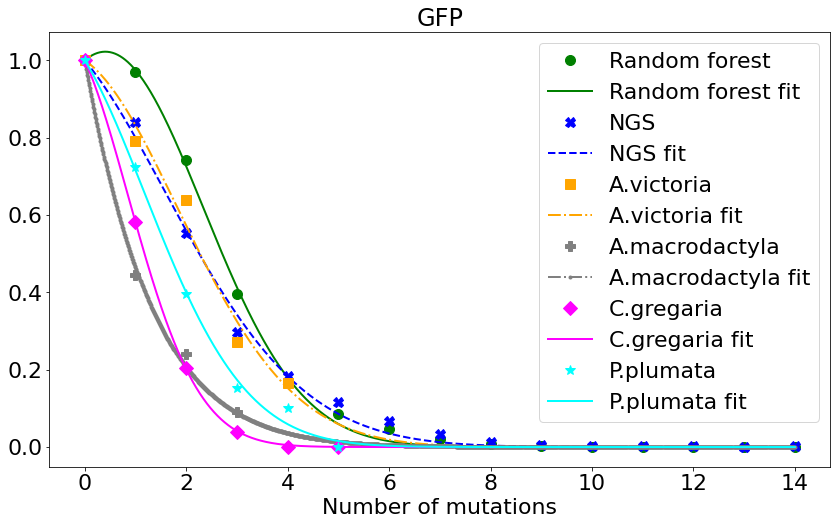

In [25]:
symbols = {'rfGFP':'o', 'ngsGFP':'X', 'avGFP':'s', 'amacGFP':'P', 'cgreGFP':'D', 'ppluGFP':'*'}
lines   = {'rfGFP':'-', 'ngsGFP':'--', 'avGFP':'-.', 'amacGFP':'-..', 'cgreGFP':'-', 'ppluGFP':'-'}
colors  = {'rfGFP':'green', 'ngsGFP':'blue', 'avGFP':'orange', 'amacGFP':'gray', 'cgreGFP':'magenta', 'ppluGFP':'cyan'}
labels  = {'rfGFP':'Random forest', 'ngsGFP':'NGS', 'avGFP':'A.victoria', \
           'amacGFP':'A.macrodactyla', 'cgreGFP':'C.gregaria', 'ppluGFP':'P.plumata'}

plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22})

x_fit = np.asarray([x / 100 for x in range(100 * (len(fr_dict['rfGFP']) - 1) + 1)])

for item in ['rfGFP', 'ngsGFP', 'avGFP', 'amacGFP', 'cgreGFP', 'ppluGFP']:
    plt.plot([x for x in range(len(fr_dict[item]))], fr_dict[item], symbols[item], c=colors[item], \
             label=labels[item], markersize=10)
    plt.plot(x_fit, new_threshold(x_fit, A_dict[item], B_dict[item]), lines[item], c=colors[item], 
             label=labels[item] + ' fit', linewidth=2)
    
plt.legend()
plt.title('GFP', fontsize=24)
plt.xlabel('Number of mutations')